### Cropping cell from microscopy image with Otsu's Method and OpenCV

In [1]:
# Imports
import numpy as np
from skimage.filters import threshold_otsu
from PIL import Image
import matplotlib.pyplot as plt
import skimage
from torch.nn import Conv2d
import torch
import cv2
import time
from random import sample

In [2]:
# Helper functions
def load_and_process_image(path = "26118-I10-4.npz"):
    img_gray = np.load(path)["sample"][:,:,2]
    img_rgb = cv2.cvtColor(img_gray,cv2.COLOR_GRAY2RGB)
    img_gray = img_gray <= threshold_otsu(img_gray, nbins = 1024)
    img_gray = np.where(img_gray, 0, 1)
    
    thresh = cv2.threshold(img_gray.astype(np.uint8),0,1,cv2.THRESH_BINARY)[1]
    plt.imshow(thresh, cmap = "gray")
    result = img_rgb.copy()
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    list_centers = []
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.circle(result, (int(x+(w/2)), int(y+(h/2))), radius=2, color=(0, 0, 255), thickness=-1)
        list_centers.append((x+(w/2), y+(h/2)))
    return(result, list_centers)


def cell_crop(list_centers, path = "26118-I10-4.npz", h = 64, w = 64):
    img_gray = np.load(path)["sample"]
    list_image = []
    for dye in range(5):
        channel = img_gray[:,:,dye]
        #channel = cv2.cvtColor(channel,cv2.COLOR_GRAY2RGB)
        list_crop = []
        for center in list_centers:
            x = int(center[0]-(w*0.5))
            y = int(center[1]-(h*0.5))
            
            if x>=0 and y>=0 and x+w<=696 and y+h<=520:
                crop_img = channel[y:y+h, x:x+w]
                list_crop.append(crop_img)
            else:
                continue
            #cv2.rectangle(channel, (x, y), (x+width, y+height), (0, 255, 0), 2)
        list_image.append(list_crop)
    return(list_image)

In one of my projects, I needed to crop single cells out of microscopy images for a modelling task. The requirement is to do everything in Python, and not to use third-party softwares.

Here is how I did it, using **Otsu's method** 

--------------------------------------------------------------------------------------------------------------------------------

# Brief intro to Cell Painting Images:
    
For the same view, we 'paint' different cell component with a different dye (of different excitation ranges) to observe morphological changes. 

The result is 5 'color channels' for each view (like, say, normal RGB images have 3 channels.) 

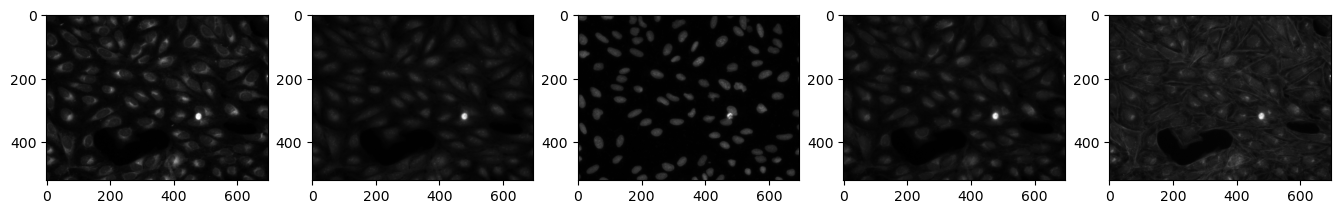

In [3]:
fig = plt.figure(figsize=(20, 3))
counter=1
for i in range(5):
    fig.add_subplot(1, 6, counter)
    plt.imshow(np.load('26118-I10-4.npz')["sample"][:,:,i], cmap = "gray")
    counter+=1

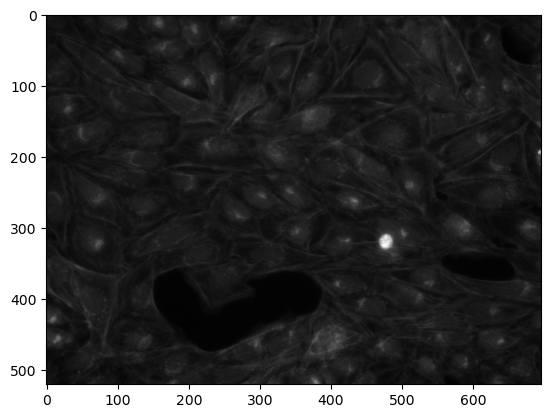

In [4]:
# Up close the 'Ph_golgi' channel
# Golgi body dyed by Phalloidin/Alexa Fluor 594 conjugate, wheat germ agglutinin (WGA)/Alexa Fluor 594 conjugate
plt.imshow(np.load('26118-I10-4.npz')["sample"][:,:,4], cmap = "gray")

---

# The mission

... is to crop cells in all 5 channels, centered on the nucleus. The cropped cells should align perfectly over 5 channels 

# The method

... is called **Otsu's method**. It is actually a quite popular for cell cropping. 

So how does it work?

https://en.wikipedia.org/wiki/Otsu%27s_method#Algorithm

tl,dr (too long, didn't read): The algorithm returns a **single intensity threshold** that separate pixels into two classes, foreground and background.

We can use this to 'pop' objects out of the background

---------------------------------------------

# 1. Pop the nucleus out

Channel 'Hoechst' is responsible for dyeing the nucleus

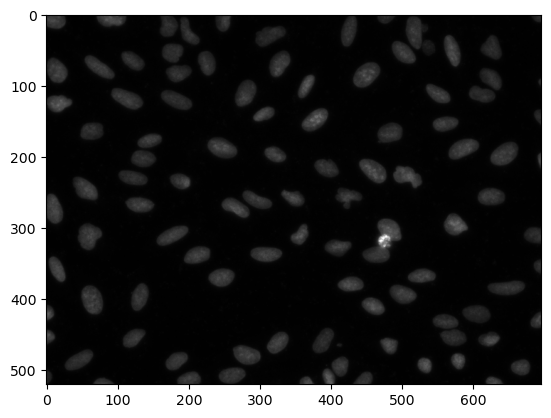

In [5]:
plt.imshow(np.load('26118-I10-4.npz')["sample"][:,:,2], cmap = "gray")

We use this channel to 'pop' the nuclei out from the dark background

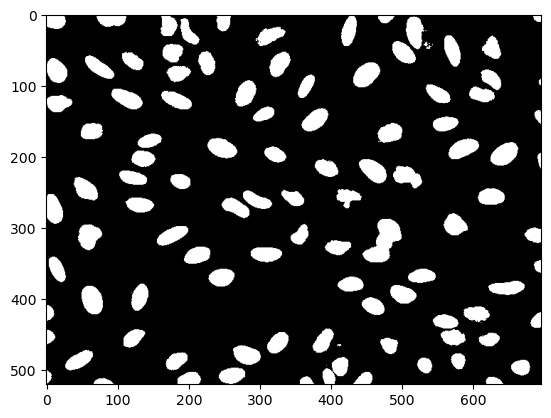

In [6]:
result, list_centers = load_and_process_image()

# 2. Find the centers of the nuclei

Based on the 'popped' nuclei, we can draw the bounding box surrounding the nuclei (with openCV), and find the **centers** of the nuclei (blue dot).

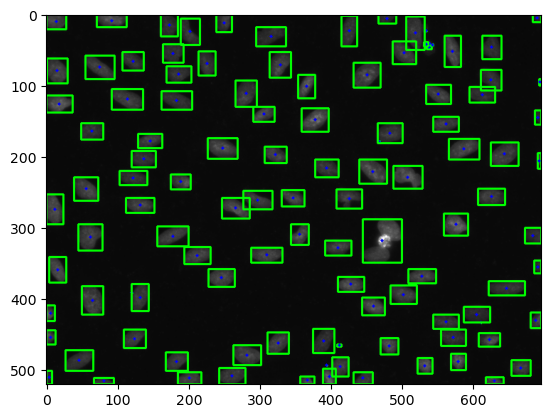

In [7]:
plt.imshow(result, cmap = "gray")

These **centers** will be the center of our 64x64 cropped cell image

# 3. Crop cells into 64x64 images

We need all images to be of the same size for Machine Learning modelling.

In [8]:
list_image = cell_crop(list_centers)

Samples of cropped cells:

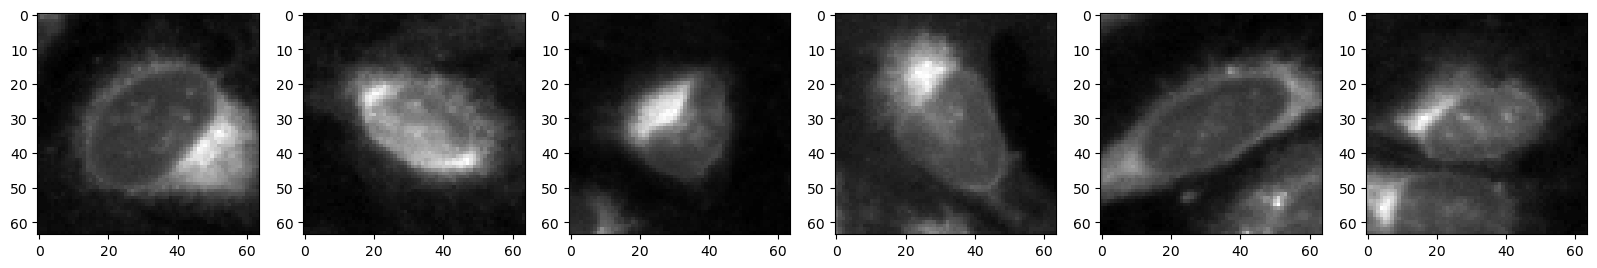

In [9]:
random_list = sample(range(len(list_image[0])),6)
fig = plt.figure(figsize=(20, 3))
counter=1
for i in random_list:
    fig.add_subplot(1, 6, counter)
    plt.imshow(list_image[0][i], cmap = "gray")
    counter+=1

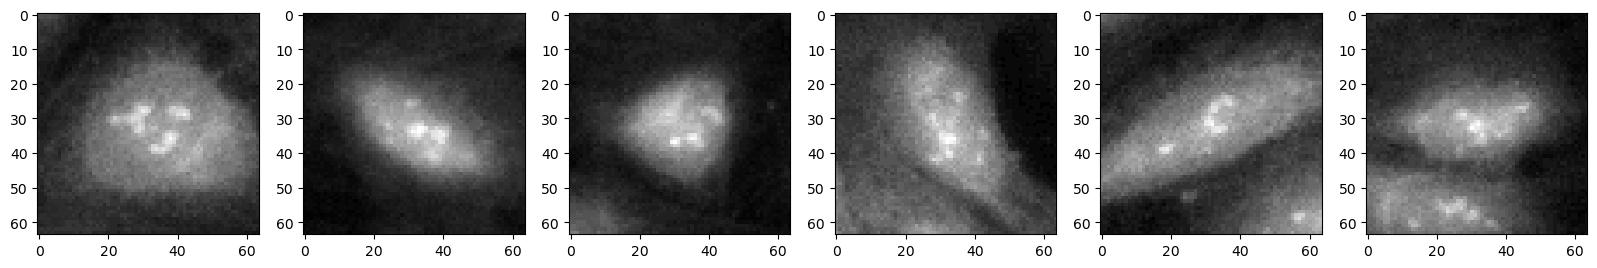

In [10]:
#Sample 6 cropped cells from Ph_golgi
fig = plt.figure(figsize=(20, 3))
counter=1
for i in random_list:
    fig.add_subplot(1, 6, counter)
    plt.imshow(list_image[1][i], cmap = "gray")
    counter+=1

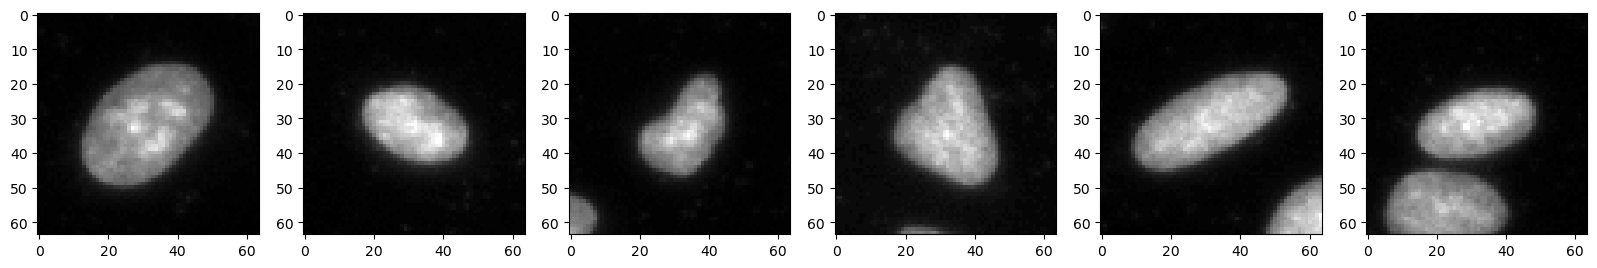

In [11]:
#Sample 6 cropped cells from ER_Syto
fig = plt.figure(figsize=(20, 3))
counter=1
for i in random_list:
    fig.add_subplot(1, 6, counter)
    plt.imshow(list_image[2][i], cmap = "gray")
    counter+=1

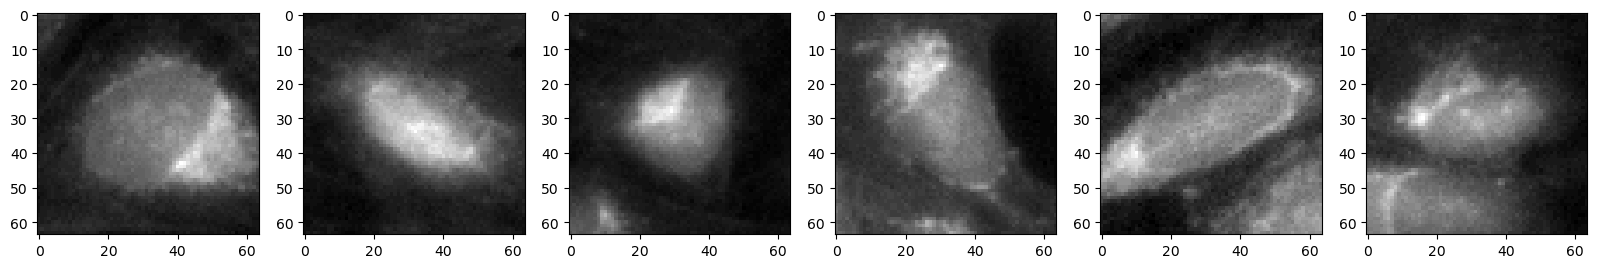

In [12]:
#Sample 6 cropped cells from Hoechst
fig = plt.figure(figsize=(20, 3))
counter=1
for i in random_list:
    fig.add_subplot(1, 6, counter)
    plt.imshow(list_image[3][i], cmap = "gray")
    counter+=1

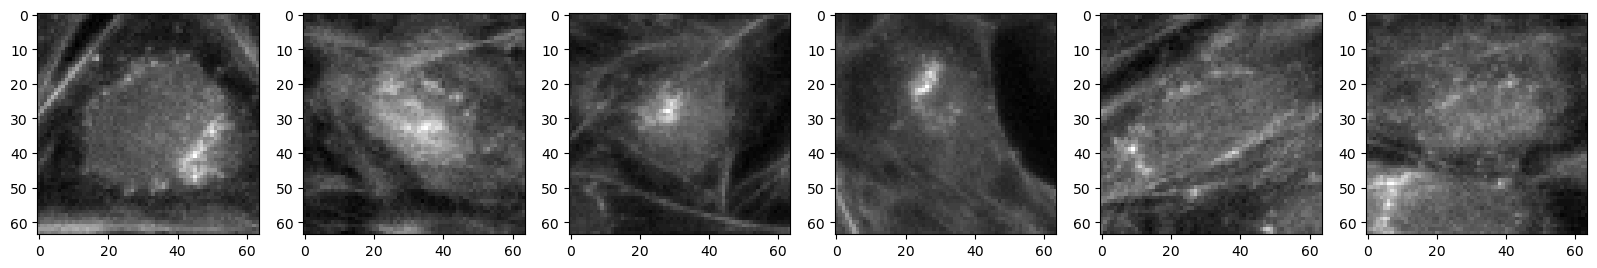

In [13]:
#Sample 6 cropped cells from ERSytoBleed
fig = plt.figure(figsize=(20, 3))
counter=1
for i in random_list:
    fig.add_subplot(1, 6, counter)
    plt.imshow(list_image[4][i], cmap = "gray")
    counter+=1

# 4. Pros and Cons

###### Pros: 

Quick to implement

Easy to understand mathematically

###### Cons:

Cells which are close together might be mistaken as one whole cell. 

Cannot distingiush between nuclei and light arfifacts from the microscope.

(look below)

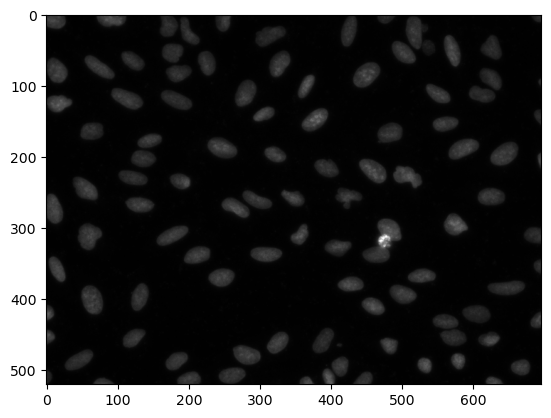

In [14]:
plt.imshow(np.load('26118-I10-4.npz')["sample"][:,:,2], cmap = "gray")

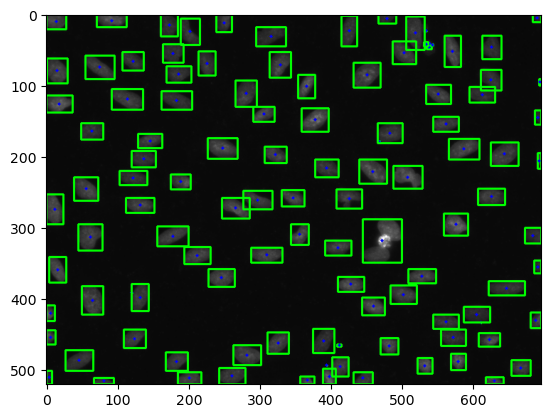

In [15]:
plt.imshow(result, cmap = "gray")